In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 

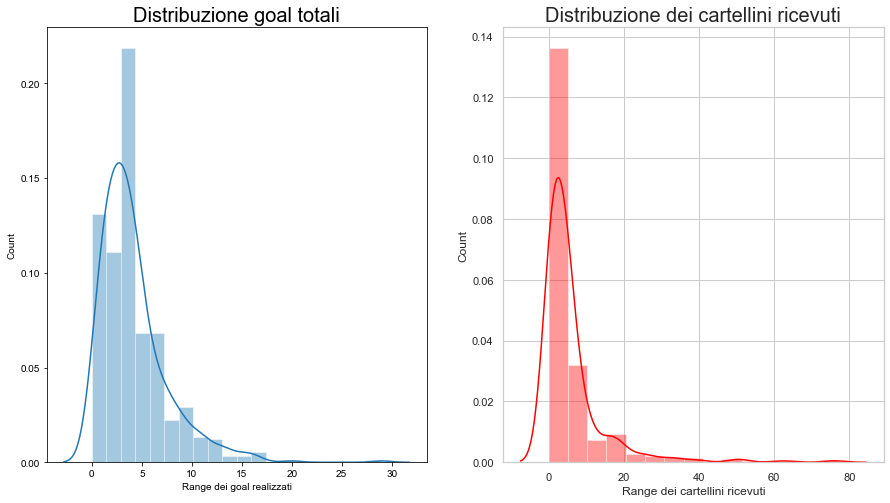

In [2]:
df_match_stats = pd.read_csv("./ETL_Mat/stats_appearences.csv")


plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df_match_stats['total_teams_score'], kde=True, bins=20)
plt.title('Distribuzione goal totali', fontsize = 20)
plt.xlabel('Range dei goal realizzati')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df_match_stats['yellow_card'], color = 'red',kde=True, bins=15)
plt.title('Distribuzione dei cartellini ricevuti', fontsize = 20)
plt.xlabel('Range dei cartellini ricevuti')
plt.ylabel('Count')
plt.show()

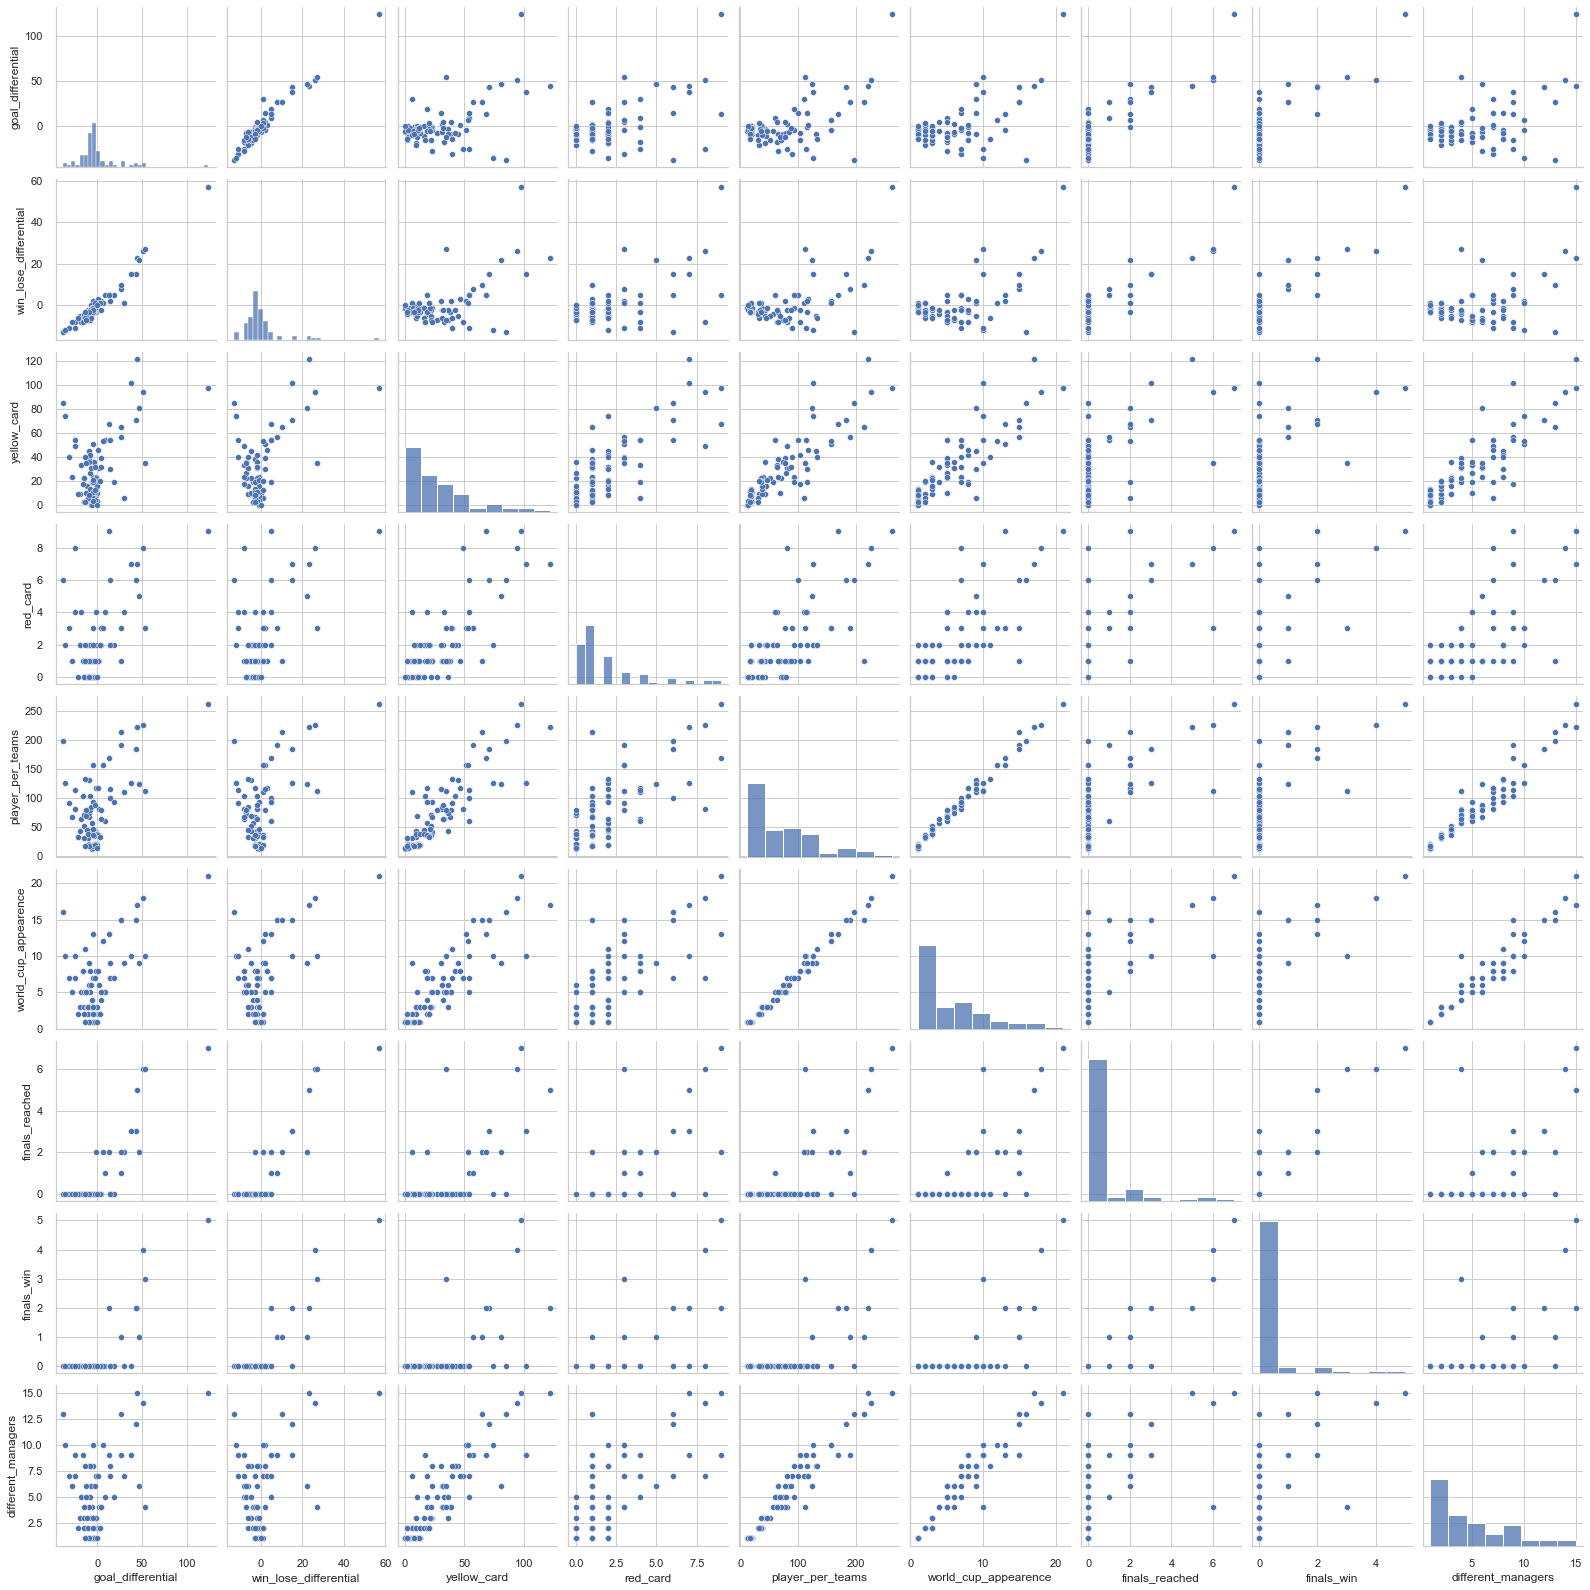

In [72]:
sns.pairplot(df_match_stats.drop(["match_name"], axis=1))

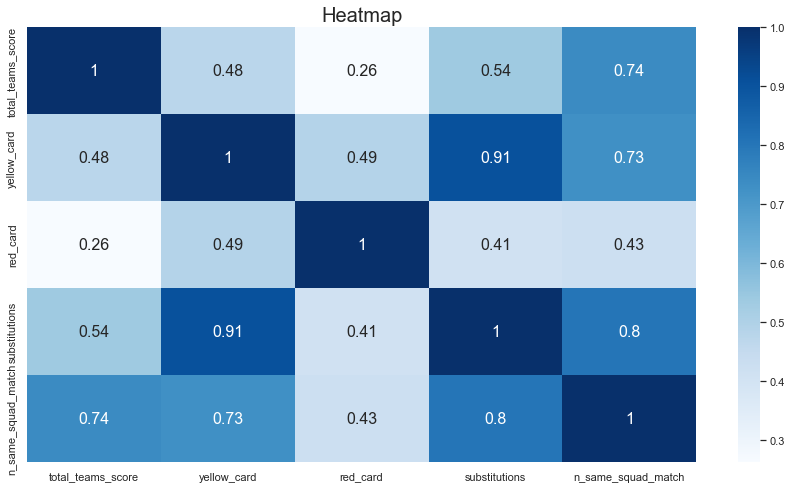

In [3]:
plt.figure(figsize=(15,8))
sns.heatmap(df_match_stats.drop(["match_name"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)
plt.show()

In [6]:
#normalizzazione
scaler = StandardScaler()
df_match_stats_std = scaler.fit_transform(df_match_stats.drop(["match_name"], axis=1))
print(np.mean(df_match_stats_std),np.std(df_match_stats_std))
print(df_match_stats_std.shape)

1.5019602544522443e-17 1.0
(615, 5)


Text(0, 0.5, 'Varianza comulativa')

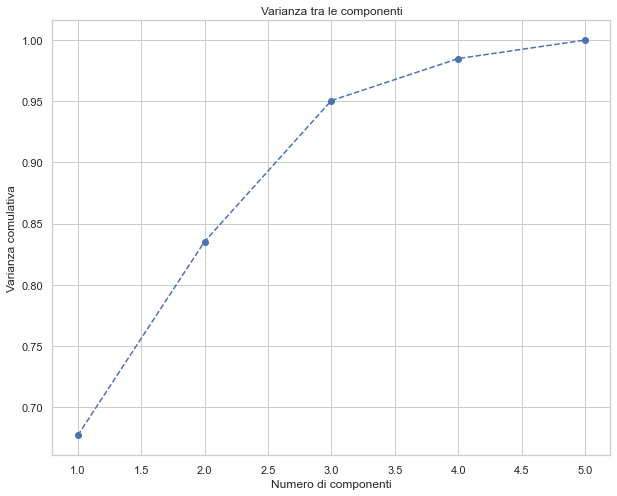

In [7]:
pca = PCA()
pca.fit(df_match_stats_std)
pca.explained_variance_ratio_

plt.figure(figsize=(10,8))
plt.plot(range(1,df_match_stats_std.shape[1]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Varianza tra le componenti')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza comulativa')

In [8]:
#prendiamo l'80% della varianza comulativa quindi 4 componenti
pca = PCA(n_components = 3, svd_solver='full')
pca.fit(df_match_stats_std)

PCA(n_components=3, svd_solver='full')

In [9]:
scores_pca = pca.transform(df_match_stats_std)
print(scores_pca.shape)

(615, 3)


In [10]:
#Elbow Method
wcss = []
for i in range(1,50):
    kmeans_pca = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS')

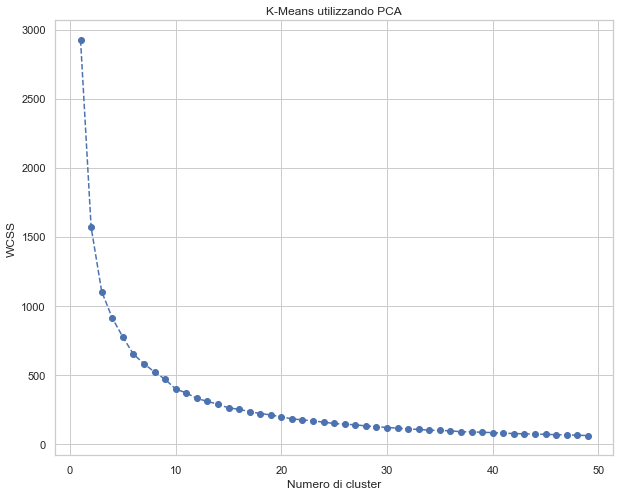

In [11]:
plt.figure(figsize=(10,8))
plt.plot(range(1,50),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')

In [12]:
#numero di cluster
kl = KneeLocator(range(1,50),wcss,curve="convex",direction="decreasing")
print(kl.elbow)
kmeans_pca = KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

10


KMeans(n_clusters=10, random_state=42)

In [13]:
#visualizzazione risultati
df_segm_pca_kmeans = pd.concat([df_match_stats.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['C-1','C-2','C-3']
df_segm_pca_kmeans['Segm K-means PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segm K-means PCA'].map({0:'primo',1:'secondo',2:'terzo',
3:'quarto',4:'quinto',5:'sesto',6:'settimo',7:'ottavo',8:'nono',9:'decimo'
})
#,8:'nono',9:'decimo'
df_segm_pca_kmeans.head()

,match_name,total_teams_score,yellow_card,red_card,substitutions,n_same_squad_match,C-1,C-2,C-3,Segm K-means PCA,Segment
0,Algeria v Austria,2,1,0,4,1,-1.082804,0.094624,-0.187405,0,primo
1,Algeria v Belgium,3,2,0,6,1,-0.810996,-0.048749,-0.151568,0,primo
2,Algeria v Brazil,1,0,0,4,1,-1.255913,0.235293,-0.310715,0,primo
3,Algeria v Chile,5,1,0,4,1,-0.726113,-0.375933,0.334894,4,quinto
4,Algeria v England,0,2,0,6,1,-1.167686,0.421808,-0.673866,0,primo


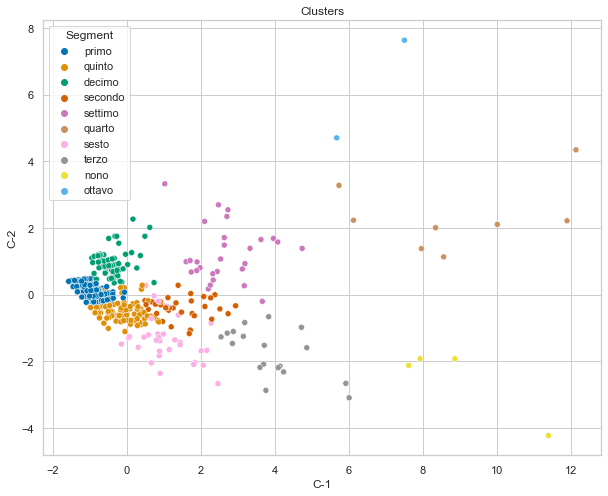

In [14]:
x_axis=df_segm_pca_kmeans['C-1']
y_axis=df_segm_pca_kmeans['C-2']
plt.figure(figsize=(10,8))
sns.scatterplot(x=x_axis,y=y_axis,hue=df_segm_pca_kmeans['Segment'],palette='colorblind')
plt.title('Clusters')
plt.show()

0.42


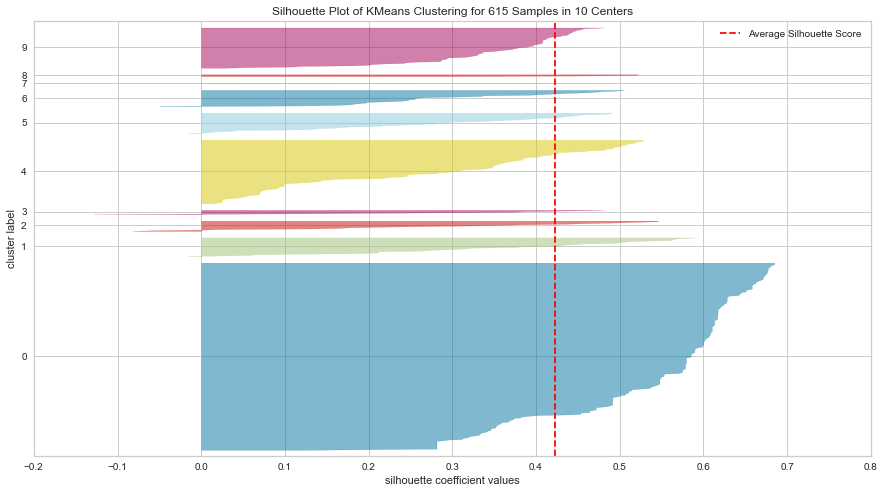

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 615 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
kmeans_silhuouette = silhouette_score(scores_pca,kmeans_pca.labels_).round(2)
print(kmeans_silhuouette)
from yellowbrick.cluster import SilhouetteVisualizer


# Instantiate the clustering model and visualizer
model = KMeans(10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

plt.figure(figsize=(15,8))
visualizer.fit(scores_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [17]:
#df_players = pd.read_csv(PATH_FROM_READ_ANALYSIS+"match.csv")
#df_segm_pca_kmeans_2 = df_players[["player_id","family_name","given_name"]].merge(df_segm_pca_kmeans,how="right",on="player_id")
df2 = pd.DataFrame()
#df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==0].describe()
for i in range(0,11):
    df = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    df.drop(["C-1","C-2"],axis=1,inplace=True)
    df.to_csv("clusters/clusters_team/cluster_"+str(i)+".csv",index=False)
    #df = df[["total_games_played","n_minutes_played","n_tournaments","n_tournaments_played","total_final_match_played","n_wc_wins","total_goals","total_penalty_scored"]]
    #,"yellow_card","red_card","total_own_goals"
    #average = df.mean()
    #average["group"] = i
    #total = df.count()
    #average.name = 'mean'
    #df2 = df2.append(average)
#df2


(615, 3)


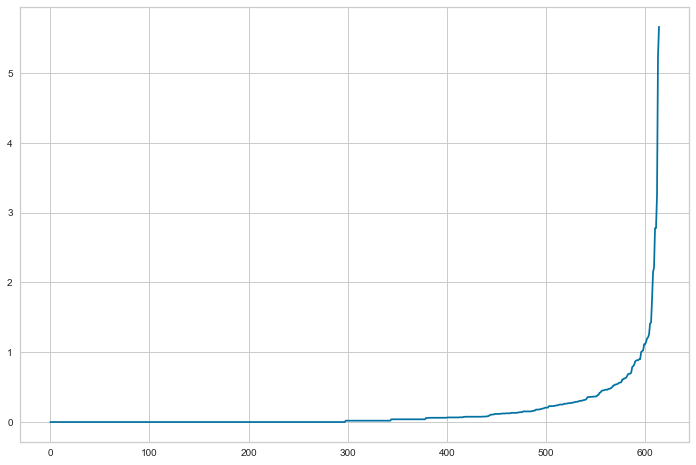

In [18]:
#DB-SCAN

from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scores_pca)
distances, indices = nbrs.kneighbors(scores_pca)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])
print(scores_pca.shape)

In [27]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.7, min_samples=5).fit(scores_pca)
ymeans = db.labels_
print(set(ymeans))
df_segm_pca_dbScan= pd.concat([df_match_stats.reset_index(drop=True),pd.DataFrame(ymeans)],axis=1)
df2 = pd.DataFrame()
for i in range(-1,len(set(ymeans))-1):
    df = df_segm_pca_dbScan[df_segm_pca_dbScan[0]==i]
    df.to_csv("clusters/cluster_team_dbscan/cluster_"+str(i)+".csv",index=False)
    #df = df[["total_games_played","n_minutes_played","n_tournaments","n_tournaments_played","total_final_match_played","n_wc_wins","total_goals","total_penalty_scored"]]
    #,"yellow_card","red_card","total_own_goals"
    #average = df.mean()
    #total = df.count()
    #average.name = 'mean'
    #total.name = 'total'
    #df2 = df2.append(average)
    #df2 = df2.append(total)
dbscan_silhuouette = silhouette_score(scores_pca,db.labels_).round(2)
print(dbscan_silhuouette)
#df2

#db = DBSCAN(eps=1.8, min_samples=5)
#visualizer = SilhouetteVisualizer(db, colors='yellowbrick',estimator=db)

#plt.figure(figsize=(15,8))
#visualizer.fit(scores_pca)        # Fit the data to the visualizer
#visualizer.show()     

{0, 1, 2, 3, 4, 5, -1}
0.16


In [21]:
#Metodo per trovare eps
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [22]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 1.1, 0.1)]
min_samples_to_test = range(5, 50, 5)

print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scores_pca, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

EPS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIN_SAMPLES: [5, 10, 15, 20, 25, 30, 35, 40, 45]
ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.581   14
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.497   11
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.377    3
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.358    3
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.333    3
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.288    1
  7 | Tested with eps = 0.1 and min_samples =  35 |  0.27    0
  8 | Tested with eps = 0.1 and min_samples =  40 |  0.27    0
  9 | Tested with eps = 0.1 and min_samples =  45 |  0.27    0
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.728   17
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.552    6
 12 | Tested with eps = 0.2 and min_samples =  15 |  0.54    6
 13 | T

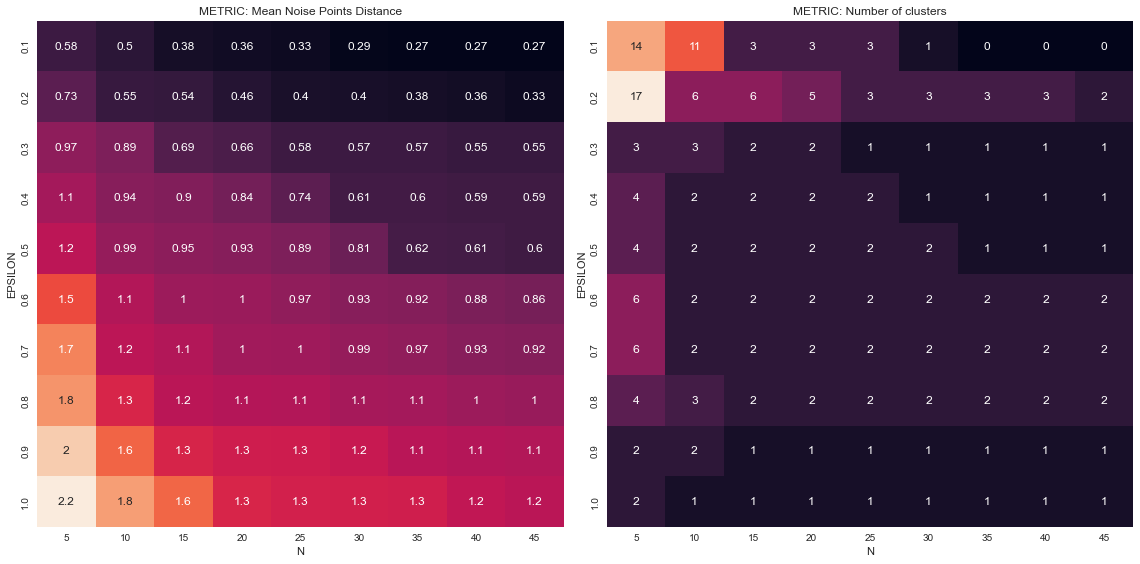

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")
#plt.rcParams['font.size'] = '20'
plt.tight_layout(); plt.show()